# Results from training on simulated HPF data

January 2022

gully


In this demo we make simulated HPF data drawn from the real blasé model.

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator, SparsePhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm
import os

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 500,000 lines.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [4]:
spectrum = PHOENIXSpectrum(teff=4100, logg=3.5)#, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

In [6]:
emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.01)

Initializing a sparse model with 11759 spectral lines


In [7]:
emulator.to(device)

SparsePhoenixEmulator()

In [10]:
import copy

In [11]:
state_dict_init = copy.deepcopy(emulator.state_dict())

In [12]:
state_dict_init['lam_centers'].shape

torch.Size([11759])

In [13]:
state_dict_post = torch.load('../examples/sparse_T4100g3p5_prom0p01_HPF.pt')

In [14]:
emulator.load_state_dict(state_dict_post)

<All keys matched successfully>

In [16]:
%%time
with torch.no_grad():
    spec_out = emulator.forward().cpu().numpy()

CPU times: user 1.79 s, sys: 1.18 s, total: 2.96 s
Wall time: 621 ms


## Read in real data

In [17]:
from muler.hpf import HPFSpectrum

In [18]:
dir = '~/GitHub/star-witness/data/HPF/goldilocks/UT21-3-015/'
dir = os.path.expanduser(dir)
fn = 'Goldilocks_20210919T084302_v1.0_0063.spectra.fits'
raw_data = HPFSpectrum(file=dir+fn, order=5)

In [19]:
data = raw_data.sky_subtract().deblaze().normalize().trim_edges((8,2040))

In [20]:
#data.plot(ylo=0)

In [21]:
wl = emulator.wl_native[emulator.active_mask].numpy()
flux = emulator.flux_native[emulator.active_mask].numpy()

## Make synthetic data with real HPF-like sampling

In [22]:
from blase.emulator import EchelleModel

In [23]:
model = EchelleModel(data.spectral_axis.bin_edges.value, emulator.wl_native)

In [24]:
model.to(device)

EchelleModel()

Convert HPF resolution in FWHM to $\sigma$:

In [25]:
n_lines = len(emulator.amplitudes)

In [26]:
perturbed_mask = torch.rand(n_lines) < 0.20

In [27]:
perturbed_mask = perturbed_mask.to(torch.float64)

In [28]:
n_perturbed = perturbed_mask.sum()
n_perturbed

tensor(2349., dtype=torch.float64)

In [29]:
offsets = 1.0*(torch.rand(n_lines, dtype=torch.float64)-0.9)

In [30]:
offsets_perturbed = offsets*perturbed_mask

In [31]:
offsets_perturbed[0:20]

tensor([-0.0000, -0.7660, -0.0000, -0.0000, -0.8822, -0.3705, -0.1352, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000,  0.0829,  0.0000, -0.0000, -0.2125,
        -0.0000, -0.0000, -0.0000, -0.0000], dtype=torch.float64)

In [32]:
perturbed_mask[0:20]

tensor([0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0.], dtype=torch.float64)

In [34]:
perturbed_state_dict = copy.deepcopy(emulator.state_dict())
perturbed_state_dict['amplitudes'] = perturbed_state_dict['amplitudes'] + offsets_perturbed

In [37]:
emulator.state_dict()['amplitudes'][0:20]

tensor([-2.8509, -6.0667, -4.7868, -4.9723, -3.9827, -6.3158, -4.7145, -4.6315,
        -2.3278, -5.2083, -6.5509, -6.3941, -4.8148, -2.9893, -2.3785, -4.5081,
        -4.6849, -3.9191, -5.6076, -4.6071], dtype=torch.float64)

In [38]:
perturbed_state_dict['amplitudes'][0:20]

tensor([-2.8509, -6.8328, -4.7868, -4.9723, -4.8649, -6.6863, -4.8497, -4.6315,
        -2.3278, -5.2083, -6.5509, -6.3941, -4.7319, -2.9893, -2.3785, -4.7206,
        -4.6849, -3.9191, -5.6076, -4.6071], dtype=torch.float64)

In [39]:
torch.save(perturbed_state_dict, "../experiments/02_synthetic_injection/model_T4100g3p5_prom0p01_HPF_perturbedAmp.pt")

In [40]:
resolving_power = 55_000
dlam_FWHM = 9_000/resolving_power # Angstroms
scalar = 2.0*np.sqrt(2.0*np.log(2))
dlam_sigma = dlam_FWHM / scalar
dlam_sigma

0.06948996547811065

In [41]:
fake_sigma_angs = torch.tensor(0.07)
fake_vsini = torch.tensor(4.1)

with torch.no_grad():
    rotationally_broadened = model.rotational_broaden(emulator.forward(), fake_vsini)
    instrumeanally_broadened = model.instrumental_broaden(rotationally_broadened, fake_sigma_angs)
    noisefree_signal = model.resample_to_data(instrumeanally_broadened)

In [42]:
emulator.load_state_dict(perturbed_state_dict)

<All keys matched successfully>

In [43]:
fake_sigma_angs = torch.tensor(0.07)
fake_vsini = torch.tensor(4.1)

with torch.no_grad():
    rotationally_broadened = model.rotational_broaden(emulator.forward(), fake_vsini)
    instrumeanally_broadened = model.instrumental_broaden(rotationally_broadened, fake_sigma_angs)
    noisefree_signal_perturbed = model.resample_to_data(instrumeanally_broadened)

(0.0, 1.0)

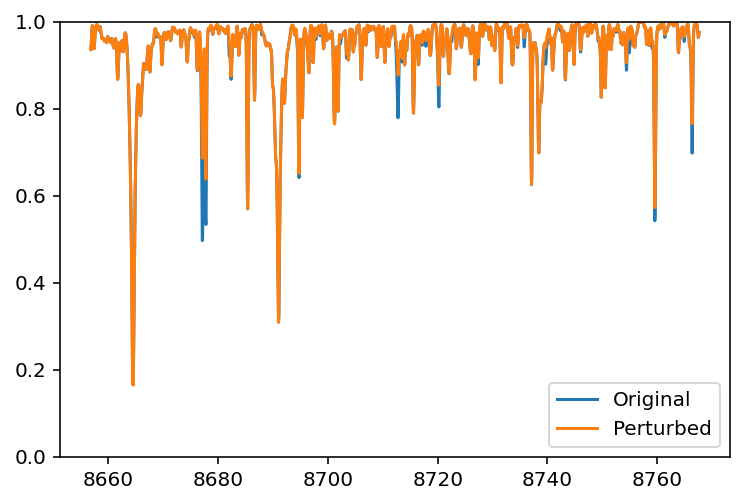

In [44]:
plt.plot(data.wavelength, noisefree_signal, label='Original');
plt.plot(data.wavelength, noisefree_signal_perturbed, label='Perturbed');
plt.legend(loc='lower right')
plt.ylim(0, 1)

In [45]:
noise_draw = np.random.normal(loc=0, scale=0.004, size=len(noisefree_signal))

In [46]:
synthetic_spectrum = noisefree_signal_perturbed + noise_draw

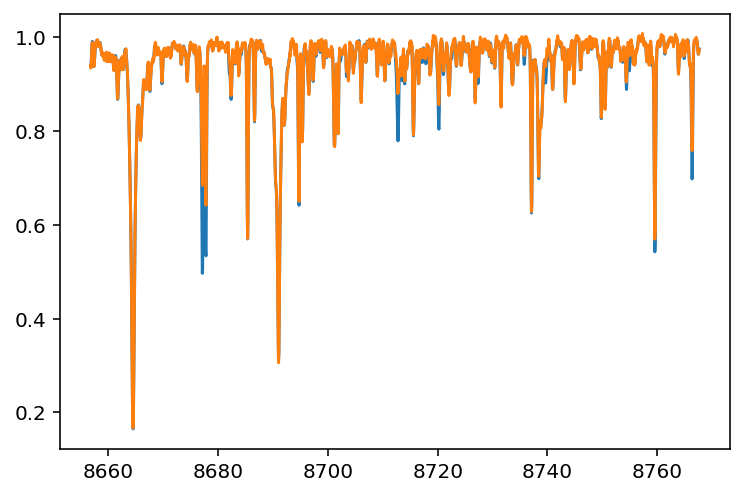

In [47]:
plt.plot(data.wavelength, noisefree_signal);
plt.plot(data.wavelength, synthetic_spectrum);


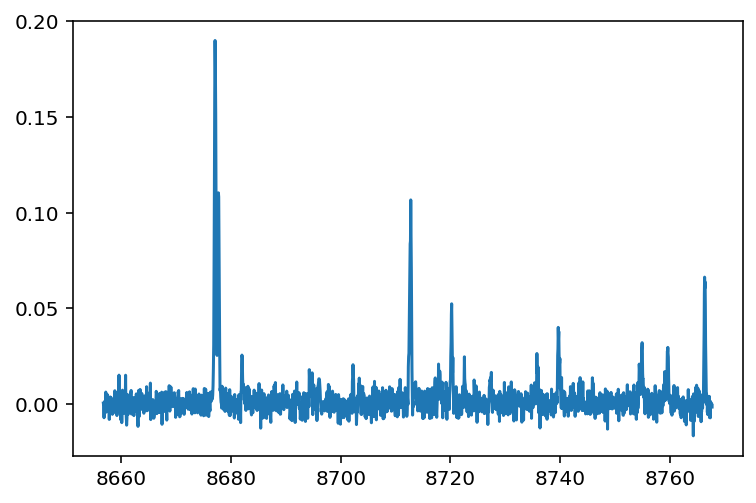

In [48]:
plt.plot(data.wavelength, synthetic_spectrum-noisefree_signal);

In [49]:
#! cp ../examples/sparse_T4100g3p5_prom0p01_HPF.pt ../experiments/02_synthetic_injection/

In [50]:
torch.save(synthetic_spectrum, '../experiments/02_synthetic_injection/synthetic_perturbed_spectrum.pt')

In [51]:
synthetic_spectrum_rt = torch.load('../experiments/02_synthetic_injection/synthetic_perturbed_spectrum.pt')

In [53]:
synthetic_spectrum_rt

tensor([0.9398, 0.9342, 0.9425,  ..., 0.9675, 0.9733, 0.9733],
       dtype=torch.float64)